# World Data League 2022

## 🎯 Challenge
**Optimization of public transport routes during road interruptions**

Cities are constantly being redesigned and maintained. Sometimes it is necessary to perform interventions on the public road and resort to traffic cuts/drifts. These disruptions on the public road not only cause inconvenience to the residents of the affected streets but to the city's entire mobility system, including public road transport.
If these cut-offs/drifts are constant, this can create situations of distrust in the reliability of the public transport network (which, even if it continues to operate, will not always run on the previously determined lines).
The goal of this challenge is to model, from the point of view of trends, which routes of the transport road network suffer the most cuts/disturbance due to interventions on public roads. We intend to evaluate the effort needed to adapt our services to match the network's needs in the presence of disruptions due to physical obstacles preventing circulation along usual routes. Additionally, we would like to evaluate and quantify levels of the perception of "inconvenience" by network users caused by different disruptions.

[Full challenge description](https://drive.google.com/file/d/1AHOGNu2cQjnZI5htiPkKlhPDSpC0_XI0/view?usp=sharing)


## 👥 Authors
* Elena Viganò
* Emil Pedersen
* Filip Claesson
* Julian Jensen
* Robert Nyquist

### TL;DR
see [Notebook with all images/graphs](https://wdl-everything-is-awesome.github.io/WDL-stage2-public/)

In [1]:
from IPython.display import Markdown, display
display(Markdown("executive_summary.md"))

# World Data League 2022

## 🎯 Challenge
*Optimization of public transport routes during road interruptions*

## 👥 Authors
* Elena Viganò
* Emil Pedersen
* Filip Claesson
* Julian Jensen 
* Robert Nyquist

## ✨ Introduction (250 words max)
Optimizing public transport is critical to maintain users trust and use of the system. In the words of Tupac Shakur:

```The most expensive thing in the world is trust. It can take years to earn and just a matter of seconds to lose.```

Our approach is to estimate the delays, using advanced network analysis, looking at the new routes during interruptions. \
Secondarily, we evalute the delay time and experienced discomfort by the residents, based on behavioural studies and as a function of number of replacement busses. \
Thirdly, we build a tool that develops new effective paths for a chosen bus route affected by a chosen disturbance. 

By using our data tools, Cascais would be able to effectively plan and excecute road maintenance, while perserving effectiveness and trust in the public transport system.

## 🔢 Data (250 words max)
* Road network from open streetmap
* List of planned roadblocks in Cascais
* Existing bus routes and time tables for Cascais

## 🧮 Methods and Techniques (250 words max)
We mapped the roads and routes to graphs. We matched the disruption data to the bus routes. \
In this way, we were able to find the routes that are affected by the disruption and that eventually will have roads closed for traffic. \
We choose a disturbance on a route and, by using standard pathfinding and graph algorithms, we recalculate the new shortest routes. \
We also estimate the loss of connectedness for bus routes, using new and different paths. \

Taking these factors into accounts into effect we found the average increase in wait time assuming same or different amount of busses. \
Through established research ( [1](https://ojp-content.s3.us-east-2.amazonaws.com/NHI/Old/BaseImages/2014/04/d.pdf) ), ( [2](https://transp-or.epfl.ch/heart/2020/abstracts/HEART_2020_paper_147.pdf) ), ( [3](https://eprints.whiterose.ac.uk/2062/1/) ), we translated this wait time to accumulated commuter dissatisfaction.


## 💡 Main Insights (300 words max)
- Caiscais should develop a good info system (as good info decrease experienced dissatisfaction by 20%)
- By taking all routes affected into account, we can find new routes for the busses, estimate new accumulated annoyance, and use it to tell how extra busses should best be allocated to the affected routes.
- Through the pathing tool developed, Cascais planners can find the most effective route for a chosen bus route affected by a chosen disturbance. 

## 🛠️ Product
Planning tool for the city of cascais to plan reroutes and additional capacity, to maintain trust in the public transport system

### Definition
Our product is data backed recommendations for the city of Cascais. We provide a model to identify possible reroutes, delays and concrete suggestions on what kind of measures the city should take to make the wait time more reasonable for Cascais public transport users in case of road disruptions.

### Users
Cascais city planners, and bus companies.

### Activities
1. The tool is able to reroute and calculate delay information.
2. The tool allows to estimate discomfort as a function of additional capacity, and precence/absence of accurate information
3. The tool allows planners to reroute a chosen route and a chosen disturbance. 

### Output
A report based on the insights analysis: See our presentation.

## 🌍 Social Impact Measurement
### Outcome
* Prediction of possible delay times for commuters due to change in bus routes caused by disruptions.
* Predition of commuter dissatisfaction.
* Possibility to take action and improve commuter mobile apps for the city of Cascais with the introduction of real time information around the roads affected by the disruption and the realistic waiting times.
* Reduction of commuters annoyance.

### Impact Metrics
- Wait time for users for public transport of Cascais (measured by taking into consideration increased time needed by the bus to follow a new route given that the primary one is closed)
- Accumulated commuter dissatisfaction

### Impact Measurement
* Based our model interpretation: We predict that disturbancies will increase wait time and commuter dissatisfaction
* Based on similar previous studies [1](https://ojp-content.s3.us-east-2.amazonaws.com/NHI/Old/BaseImages/2014/04/d.pdf): We think that improving the mobile app associated with public transport in Cascais to update commuters in real time with the correct estimation of the possible delay, riders won't perceive their wait time to be longer than their measured wait time. This would contribute to decreasing the dissatisfaction of the commuters. 
* In a 1 block cases study at the end of our anlysis, we show how optimally allocated busses can make a huge difference. Ie. when addind 300% extra busses if allocated wrongly users could still experience a **factor 3** increae in annoyance. By allocated it correctly annoyance can be reduced to **below 1** (better than normal due to the increae in busses).

## 💻 Development

### imports

In [2]:

# To surpress warnings for prettier notebook run uncomment below
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import datetime

In [3]:
import osmnx as ox
import gtfsutils as gtfsu
import numpy as np
import pandas as pd
import requests
import urllib
import geopy.distance
import pickle
from matplotlib import pyplot as plt
from ast import literal_eval


In [4]:
# GLOBAL VARS

LOAD_LOCAL = True # load from local data dumps for faster iterations

MAX_EXTRA_DRIVE_FACTOR = 1.5  
    # How long people drive extra compared to a new route. 
    # E.g. image you have 5 options for reroutes with distance 0.5 km, 0.6 km 0.7 km, 1.3 km and 3.0 km
    # The shortest is 0.5 km 
    # with a MAX_EXTRA_DRIVE_FACTOR of 1.5 we get 1.5 * 0.5 km = 0.75 km (as max distance people will travel)
    # Meaning people will use the 0.5 km, 0.6 km, 0.7 km reroutes. But not the 1.3 km or 3.0 km as they are too long compared to what is available
    # It means traffic from the old route will be redistributed to 3 new routes.
    
INTERRUPTION_SEARCH_DIST = 0.3 # km
    # Distance in kilometers from a possible road block where we search for stops, and routes affected. 
    # Increasing this distance would mean more compute time, and possibility to catch more secondary effects 
    # (Ie. when the bus route is not blocked, but a nearby route is blocked and cause slow down due to traffic.

ANNOY_FACTOR = 2 
    # We know from litterature that annoyance is non-linear with wait time. 
    # Based on estimates from reported values from other countries in particular a british metastudy
    # we choose to model it at a power function with the exponent of they annoy factor. 
    # ie Annoyance = wait_time^ANNOY_FACTOR

### HELPER FUNCTIONS

#### FORMAT GFTSM DATA

In [5]:
def get_sec(time_str):
    """Get seconds from timestamp."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)


def agment_node_id(graph,bus_info):
    """
    Match stop info with node ids from graph
    
    see also 
    https://stackoverflow.com/questions/13407468/how-can-i-list-all-the-stops-associated-with-a-route-using-gtfs
    """
    # Match to closest node (bus stops are nodes in open street map, so will pick out the correct node).
    node_ids = []
    for i in range(len(bus_info["stops"])):
        lat = bus_info["stops"].iloc[i]["stop_lat"]
        lon = bus_info["stops"].iloc[i]["stop_lon"]
        node_id = ox.distance.nearest_nodes(graph, lon,lat)
        node_ids.append(node_id)
    bus_info["stops"]["node_id"] = node_ids

    # merge stops (with node_ids) into stop_times
    bus_info["stop_times"] = bus_info["stop_times"].merge(bus_info["stops"][["stop_id","stop_lat","stop_lon","node_id"]],on="stop_id")

    # add time to next stop (set to 0 if new route is started)
    # Note they are ordered
    df = bus_info["stop_times"].sort_values(['trip_id', 'stop_sequence'],ascending = [True, True])
    df['time_diff'] = (df['arrival_time'].apply(get_sec).shift(-1) - df["arrival_time"].apply(get_sec)) * (df['trip_id'].shift(-1)==df["trip_id"])
    
    # get next bus node
    df = bus_info["stop_times"].sort_values(['trip_id', 'stop_sequence'],ascending = [True, True])
    df['next_node_id'] = (df["node_id"].shift(-1) * (df['trip_id'].shift(-1)==df["trip_id"])).fillna(0).astype(int)

    bus_info["stop_times"] = df

    # route
    bus_info["stop_times"]["bus_route"] =  bus_info["stop_times"]["trip_id"].apply(lambda x: x.split("-")[0])



#### AGUMENT ROAD BLOCK DATA

In [6]:

def get_closest_coordinate_to_road_name(road_name, api_key):
    road = urllib.parse.quote(road_name)
    url="https://geokeo.com/geocode/v1/search.php?q=" + road + ",%20Cascais&api=" + api_key

    resp = requests.get(url=url)
    data = resp.json()
    try:
        lat = float(data["results"][0]["geometry"]["location"]["lat"])
        lng = float(data["results"][0]["geometry"]["location"]["lng"])
    except:
        lat = np.nan
        lng = np.nan
    return(lat,lng)


def add_road_location(disruptions_data,api_key):
    lat_list = []
    lng_list = []
    for i,road_name in enumerate(disruptions_data.Rua.values):
        if i%20==0: 
            print(i)
        lat,lng = get_closest_coordinate_to_road_name(road_name,api_key)
        lat_list.append(lat)
        lng_list.append(lng)
    
    disruptions_data['lat'] = lat_list
    disruptions_data['lng'] = lng_list
    
def augment_with_edge_id(graph,data):
    # requires data to have columns ["lng","lat"]
    edge_ids = []
    for index, row in data.iterrows():
        temp_lng = row["lng"]
        temp_lat = row["lat"]
        edge_id = ox.distance.nearest_edges(graph,temp_lng,temp_lat) # id of nearest edge to coordinate

        #temp_nearest_node,distance_to_coord = ox.distance.nearest_nodes(cascais_roads, temp_lng, temp_lat, return_dist=True)
        edge_ids.append(edge_id)
        data["edge_id"] = edge_ids



#### FIND NEW ROUTE AVOIDING DISTURBANCE 

In [7]:
###  helper_functions
def find_bus_route_nodes(bus_info, trip_id):
    bus_info_m01 = bus_info["stop_times"][bus_info["stop_times"]["trip_id"]==trip_id]
    bus_info_m01 = bus_info_m01.reset_index()
    start = bus_info_m01["node_id"][:-1]
    end = bus_info_m01["next_node_id"][:-1]
    return(start, end)

def collect_paths(paths):
    route_nodes = []
    for i in range(0, len(paths)):
        route_nodes = route_nodes + paths[i][:-1]
    return(route_nodes)

def new_route_graph(cascais_roads, test_disturbance, disruptions_data_sample, figsize, start, end):
    cascais_roads_node_removed = cascais_roads.copy()
    cascais_roads_node_removed.remove_node(test_disturbance)

    start_removed = start[start!=test_disturbance]
    end_removed = end[end!=test_disturbance]

    paths = ox.shortest_path(cascais_roads_node_removed, start_removed, end_removed)

    route_nodes = collect_paths(paths)

    nc = ['blue' if (u in disruptions_data_sample["nearest_node"].values and u in route_nodes) else "red" if (u in disruptions_data_sample["nearest_node"].values) else "purple" if (u in route_nodes) else 'white' for u in cascais_roads_node_removed.nodes()] 
    ns = [50 if (u in disruptions_data_sample["nearest_node"].values and u in route_nodes) else 20 if (u in disruptions_data_sample["nearest_node"].values) else 20 if (u in route_nodes) else 5 for u in cascais_roads_node_removed.nodes()] 

    ox.plot_graph_route(cascais_roads_node_removed, route_nodes, node_zorder=3, node_color=nc, node_size=ns, route_color="green",route_linewidth=5, figsize=figsize) 

    return(route_nodes)

#### CALCULATE DELAYS AND EFFECTS

In [8]:
def route2dist(graph,route):
    """
    Takes a graph and route (list of notes and calculate the total length    
    """
    return sum([graph.edges[u,v,0]['length'] for u, v in zip(route, route[1:])])

def delay_by_block(graph,node1,node2,block=None,maxfactor=1.5):
    """
    Input
        graph : networkx graph
        node1 : node_id = id of first stop
        node2 : node_id = id of second stop
        block : edge_id (node_id1, node_id2) = street that is blocked
        maxfactor : float = how long people are willing travel to circumvent the block compared
            to the new shortest route. Default value is 1.5
            meaning if there is 1 km reroute, people would also use a 1-1.5 km reroute but not longer routes.
    Output
        extra_dealay_factor : float = factor how much longer this stretch takes
        new_path : route (list of node_ids) = new route the bus would take
        
    Function that calculate the extra delay factor compared to normal distance in routes. 
    It takes into account additional traffic caused by all the cars that also would need to reroute, 
    """
    paths = list(ox.distance.k_shortest_paths(cascais_roads,node1,node2,10,weight="length"))
    blocked = np.array([block in zip(route, route[1:]) for route in paths])
    distance = np.array(list(map(lambda x: route2dist(graph,x),paths)))
    
    shortest = min(distance)
    new_shortest = min(distance+1E6*blocked)
    idx = np.where(distance==new_shortest)[0][0]    
    new_path = paths[idx]
    
    n_paths = sum(distance<=new_shortest*maxfactor)
    extra_length_factor = new_shortest/shortest 
    extra_traffic_factor = n_paths/(n_paths-sum(blocked))
    
    extra_delay_factor = extra_length_factor * extra_traffic_factor
    
    return extra_delay_factor,new_path



### DATA

#### OPEN STREET MAP INFO

In [9]:
# get road info
cascais_roads = ox.graph_from_place("Cascais, Lisbon, Portugal", network_type='drive', simplify=True)

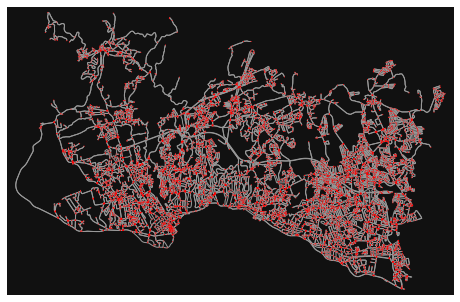

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
ox.plot_graph(cascais_roads,node_size=1,node_color="red")

#### PLANNED ROAD MAINTENANCE

In [11]:
# Road Disruptions - MNIVP
if(LOAD_LOCAL):
    road_disruptions_csv = "../data/challenge_2/mnivp.csv"
    disruptions_data = pd.read_csv(road_disruptions_csv,sep=";",encoding='latin1')
else:
    road_disruptions_csv="https://dadosabertos.cascais.pt/pt_PT/dataset/0d9193e7-aa5f-4c18-b826-55b11965acd4/resource/88cdf865-0955-4629-9019-12d36fb48693/download/mnivp.csv"
    disruptions_data = pd.read_csv(road_disruptions_csv,sep=";",encoding='latin1')

# drop 56 entries which does not have a street name
disruptions_data = disruptions_data[disruptions_data['Rua'].notna()]
disruptions_data_sample = disruptions_data.head(100).copy()


# AGMENT by looking up the street name and trasnlate to longitude and lattitude
# Uses https://geokeo.com free tier (limited to 2500 requet per day). 
if(LOAD_LOCAL):
    disruptions_data_sample = pd.read_csv("../data/challenge_2/disruption_data_sample.csv")
else:
    api_key = "" # ADD YOU API KEY 
    add_road_location(disruptions_data_sample,api_key)
    augment_with_edge_id(cascais_roads,disruptions_data_sample)
    disruptions_data_sample.to_csv("../data/challenge_2/disruption_data_sample.csv")



In [12]:
disruptions_data_sample.head(2) 

,Unnamed: 0.1,Unnamed: 0,Id,Requerente,Tipo de Trabalho,Rua,Freguesia,Data de actualização,Data Prevista de Inicio,Data Prevista de Fim,Número do Processo,Estado,Recepção Provisória,Ano,Recepção Definitiva,lat,lng,nearest_node,distance_to_coord,edge_id
0,0,0,44611945,Particular,Rede elétrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,24-04-2020,24-04-2020,WW227609,Em execução,NaN,2020,NaN,38.733111,-9.411752,672196477,74.438031,"(3692592273, 3664557855, 0)"
1,1,1,44522015,Particular,Rede elétrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,14-04-2020,13-04-2020,WW226781,Em execução,NaN,2020,NaN,38.695074,-9.421715,1106417062,74.438031,"(1106416434, 1106417062, 0)"


#### GTFS DATA

In [13]:
# get bus info
bus_info = gtfsu.load_gtfs("../data/challenge_2/GTFS")

### Data prepping

In [14]:
# match to graph, and augment stop_times
if(LOAD_LOCAL):
    # load file
    file = open("../data/bus_info.obj",'rb')
    bus_info = pickle.load(file)
    file.close()
else:
    agment_node_id(cascais_roads,bus_info)
    
    # save file
    filehandler = open("../data/bus_info.obj","wb")
    pickle.dump(bus_info,filehandler)
    filehandler.close()

# reduce trips to routes
simple_routes = bus_info["stop_times"].groupby(["bus_route","stop_sequence"]).min().reset_index()

In [15]:
simple_routes.head(2)

,bus_route,stop_sequence,trip_id,arrival_time,departure_time,stop_id,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_lat,stop_lon,node_id,time_diff,next_node_id
0,M01,1,M01-1-001-A-U-09h15-ParedeTerminalR,09:15:00,09:15:00,7405,NaN,NaN,NaN,0.00,1,38.691912,-9.401172,3655471152,60.0,888784065
1,M01,2,M01-1-001-A-U-09h15-ParedeTerminalR,09:17:00,09:17:00,155665,NaN,NaN,NaN,667.36,0,38.695105,-9.395432,888784065,60.0,970256060


In [16]:
bus_info["stop_times"]["bus_route"].unique()
# bus_info["stop_times"].groupby(["bus_route"])["trip_id"].nunique()

array(['M01', 'M02', 'M03', 'M04', 'M05', 'M06', 'M07', 'M08', 'M09',
       'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18',
       'M19', 'M20', 'M21', 'M22', 'M23', 'M24', 'M25', 'M26', 'M27',
       'M28', 'M29', 'M30', 'M31', 'M32', 'M33', 'M34', 'M35', 'M36',
       'M37', 'M38', 'M39', 'M40', 'M41', 'M42', 'M43', 'M44'],
      dtype=object)

### Find route or nodes close to disruptions

In [17]:
disruptions_data_sample.head(2)

,Unnamed: 0.1,Unnamed: 0,Id,Requerente,Tipo de Trabalho,Rua,Freguesia,Data de actualização,Data Prevista de Inicio,Data Prevista de Fim,Número do Processo,Estado,Recepção Provisória,Ano,Recepção Definitiva,lat,lng,nearest_node,distance_to_coord,edge_id
0,0,0,44611945,Particular,Rede elétrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,02-06-2020 09:15,24-04-2020,24-04-2020,WW227609,Em execução,NaN,2020,NaN,38.733111,-9.411752,672196477,74.438031,"(3692592273, 3664557855, 0)"
1,1,1,44522015,Particular,Rede elétrica,Rua do Bugio,U.F. Carcavelos e Parede,06-04-2020 13:20,14-04-2020,13-04-2020,WW226781,Em execução,NaN,2020,NaN,38.695074,-9.421715,1106417062,74.438031,"(1106416434, 1106417062, 0)"


In [18]:
# Calculate distance to all stops. 
# Looks at stops within X distance if they are affected
# Where x is INTERRUPTION_SEARCH_DIST

disruptions_data_sample["dummy"] = 0
simple_routes["dummy"] = 0
df_all = disruptions_data_sample.merge(simple_routes, on="dummy", suffixes=('', ''))
df_all["dist"] = list(map(lambda x: geopy.distance.geodesic((x[0],x[1]),(x[2],x[3])).km
  ,zip(df_all.lat.values,df_all.lng.values,df_all.stop_lat,df_all.stop_lon)
     ))

df_to_check = df_all[df_all["dist"]<INTERRUPTION_SEARCH_DIST].groupby(["Id","bus_route"]).agg({'stop_sequence': [ 'min', 'max']}).reset_index()

In [19]:
df_to_check.head(10)
# block id, what routes to check and what stops 

Id bus_route stop_sequence    
                                min max
0  37718202       M01            18  18
1  37718202       M27            18  20
2  38036808       M24             3  33
3  38036808       M25            42  42
4  38036820       M01            18  18
5  38036820       M27            18  20
6  38036892       M26            13  15
7  38036892       M30            12  17
8  38036892       M33            12  13
9  38042430       M08             8  14

In [20]:
df_to_check.head(5)

Id bus_route stop_sequence    
                                min max
0  37718202       M01            18  18
1  37718202       M27            18  20
2  38036808       M24             3  33
3  38036808       M25            42  42
4  38036820       M01            18  18

In [21]:
simple_routes["node_id"].shift(-1)

0       8.887841e+08
1       9.702561e+08
2       4.596567e+08
3       3.303412e+08
4       1.506823e+09
            ...     
1454    3.881996e+08
1455    2.671068e+07
1456    3.881996e+08
1457    1.482491e+09
1458             NaN
Name: node_id, Length: 1459, dtype: float64

In [22]:
def route2dist(graph,route):
    """
    Takes a graph and route (list of notes and calculate the total length    
    """
    return sum([graph.edges[u,v,0]['length'] for u, v in zip(route, route[1:])])

def delay_by_block(graph,node1,node2,block=None,maxfactor=1.5):
    """
    Input
        graph : networkx graph
        node1 : node_id = id of first stop
        node2 : node_id = id of second stop
        block : edge_id (node_id1, node_id2) = street that is blocked
        maxfactor : float = how long people are willing travel to circumvent the block compared
            to the new shortest route. Default value is 1.5
            meaning if there is 1 km reroute, people would also use a 1-1.5 km reroute but not longer routes.
    Output
        extra_dealay_factor : float = factor how much longer this stretch takes
        new_path : route (list of node_ids) = new route the bus would take
        
    Function that calculate the extra delay factor compared to normal distance in routes. 
    It takes into account additional traffic caused by all the cars that also would need to reroute, 
    """
    try:
        paths = list(ox.distance.k_shortest_paths(cascais_roads,node1,node2,10,weight="length"))
        blocked = np.array([(block in zip(route, route[1:])) or (block in zip(route[1:], route)) for route in paths])
        #blocked = np.array([(block in zip(route, route[1:])) for route in paths])
        
        distance = np.array(list(map(lambda x: route2dist(graph,x),paths)))

        # find new path
        #print(blocked)
        shortest = min(distance)
        new_shortest = min(distance+1E10*blocked)
        idx = np.where(distance==new_shortest)[0][0]    
        new_path = paths[idx]

        # find extra factors
        n_paths = sum(distance<=new_shortest*maxfactor)
        removed_paths = sum([b and d<new_shortest*maxfactor for d,b in zip(distance,blocked)])
        extra_length_factor = new_shortest/shortest 
        extra_traffic_factor = n_paths/(n_paths-removed_paths)

        extra_delay_factor = extra_length_factor * extra_traffic_factor

        return extra_delay_factor,extra_length_factor,extra_traffic_factor,new_shortest,shortest,new_path
    
    except:
        return 1,1,1,1,1,1

#delay_factor,new_route = delay_by_block(cascais_roads,309785823, 243459163,block,MAX_EXTRA_DRIVE_FACTOR)

In [23]:



def replan_and_delay_factor(df_to_check,simple_routes,disruptions_data_sample,cascais_roads,block_list=None):

    if block_list is None:
        block_list = df_to_check["Id"].unique()
    all_blocks_list = []
    for block_id in block_list:
        #print(block_id)
        routes = df_to_check[df_to_check["Id"]== block_id].values
        block_info = {}
        block_info["block_id"] = block_id
        block_info["delays"] = []
        #print(routes)
        for r in routes:
            #print(r)
            block_id = r[0]
            block = disruptions_data_sample[disruptions_data_sample.Id==r[0]]["edge_id"].values[0]
            if(isinstance(block, str)):
                block = literal_eval(block)
            block = block[:2]
            
            #print("block",block)
            bus_route = r[1]
            stop_sequence_min = r[2]-1 
            stop_sequence_max = r[3]

            sr = simple_routes[(simple_routes.bus_route==bus_route) & 
                          (simple_routes.stop_sequence>=stop_sequence_min) &
                          (simple_routes.stop_sequence<=stop_sequence_max)][["node_id","next_node_id","stop_sequence","time_diff"]]

            total_route_time = simple_routes[(simple_routes.bus_route==bus_route)]["time_diff"].sum()

            bus = {}
            bus["route"]=bus_route
            #print(block_info)
            for stop in sr.values:                
                # don't check last stop in a route
                if(stop[1]==0 or stop[0]==stop[1]):
                    continue
                #print(stop[0],stop[1],stop[2])
                time_dif = stop[3]
                # check for any delay factor     
                extra_delay_factor,f_len, f_traffic, new_s,s,new_path = delay_by_block(cascais_roads,stop[0],stop[1],block,MAX_EXTRA_DRIVE_FACTOR)
                #print(extra_delay_factor,f_len, f_traffic, new_s,s)
                if extra_delay_factor >1:
                    total_extra_factor = (time_dif*(extra_delay_factor-1)+total_route_time) / total_route_time
                    bus["delay_factor"] = round(total_extra_factor,2)
                    bus["new_path"] = new_path
                    block_info["delays"].append(bus)
                break
        all_blocks_list.append(block_info)

    return all_blocks_list



### Annoyance calculations - Example of output
- For all bus routes affected by the block
    - calculates new delay factor (taking extra traffic into account)
    - calculates new paths needed
- Can be used to prioritize where to put extra busses (see charts below)
    - by prioritizing the routes with highest delay factor (translating into annoyances non-linearly)

In [24]:
block_list = [38036892]
block_example = replan_and_delay_factor(df_to_check,simple_routes,disruptions_data_sample,cascais_roads,block_list=block_list)
block_example

[{'block_id': 38036892,
  'delays': [{'route': 'M26',
    'delay_factor': 1.83,
    'new_path': [5326937211.0,
     1060408573,
     1060408617,
     1060408572,
     1060416826,
     1060416843,
     1060416850,
     414997789,
     414997788,
     1060259807,
     1060257245,
     1060257265,
     1060263878,
     1060263882,
     1060263885.0]},
   {'route': 'M33',
    'delay_factor': 1.13,
    'new_path': [1060247218.0,
     1060247201,
     1060247194,
     6244707192,
     6244706476,
     6244707193,
     6244707189,
     414997729,
     1060416820,
     1705568466,
     1060259824,
     1060259843,
     1060259807,
     1060257245,
     1060257265,
     1060263878,
     1060263882,
     1060263885.0]}]}]

In [25]:
block_list = df_to_check["Id"].unique()
block_reroute_info = replan_and_delay_factor(df_to_check,simple_routes,disruptions_data_sample,cascais_roads,block_list=block_list[:10])

Annoyance increse with this blockage
with info:  16 as annoyed


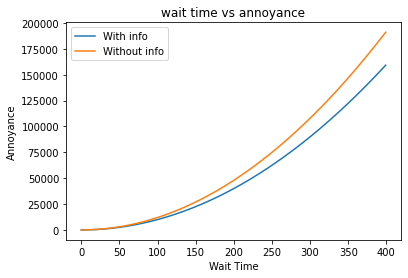

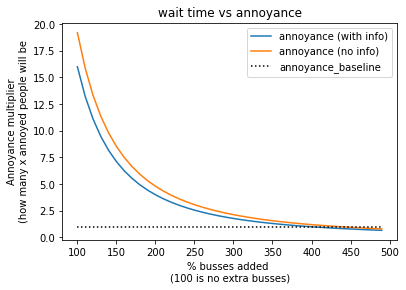

In [26]:



plt.figure(1)
x = np.arange(0,400)
y = x**ANNOY_FACTOR 
plt.plot(x,y,label="With info")
plt.plot(x,1.2*y,label="Without info")
plt.title("wait time vs annoyance")
plt.ylabel("Annoyance")
plt.xlabel("Wait Time")
plt.legend()


print("Annoyance increse with this blockage")
print("with info: ",4**ANNOY_FACTOR , "as annoyed")

plt.figure(2)
bus_factor_increase = np.arange(100,500,10)
annoy_increase_factor = (4/(bus_factor_increase/100))**ANNOY_FACTOR
plt.plot(bus_factor_increase , annoy_increase_factor, label="annoyance (with info)")
plt.plot(bus_factor_increase , 1.2*annoy_increase_factor, label="annoyance (no info)")
plt.plot(bus_factor_increase , bus_factor_increase /bus_factor_increase , ":k" , label="annoyance_baseline")
plt.title("wait time vs annoyance")
plt.ylabel("Annoyance multiplier\n(how many x annoyed people will be")
plt.xlabel("% busses added \n(100 is no extra busses)")
plt.legend()



With 50.0% extra busses, optimally 10.2% should go to route 26
With 100% extra busses, optimally 26.1% should go to route 26
With 300% extra busses, optimally 36.7% should go to route 26


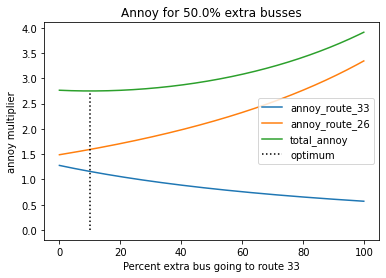

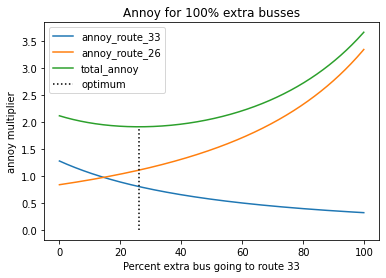

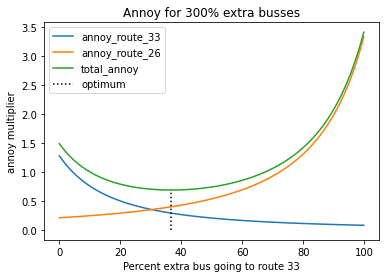

In [27]:
# Optimizing extra busses

# Example above with 
# M33','delay_factor': 1.13,
# M26, 'delay_factor': 1.83,

def sim_bus_distribution(extra_bus=.5): 
    plt.figure()
    percent_33 = np.arange(0,100,.1)
    extra_bus_percent = extra_bus*100

    annoy_33 = (1.13/(1+extra_bus*percent_33/100))**ANNOY_FACTOR
    annoy_26 = (1.83/(1+extra_bus*(100-percent_33)/100))**ANNOY_FACTOR
    total_annoy = annoy_33 + annoy_26

    min_total_annoy = min(total_annoy)
    idx = np.argmin(total_annoy)
    x = percent_33[idx]

    plt.plot(percent_33,annoy_33,label="annoy_route_33")
    plt.plot(percent_33,annoy_26,label="annoy_route_26")
    plt.plot(percent_33,total_annoy,label="total_annoy")
    plt.plot([x,x],[0,min_total_annoy],'k:',label="optimum")
    plt.xlabel("Percent extra bus going to route 33")
    plt.ylabel("annoy multiplier")
    plt.title(f"Annoy for {extra_bus_percent}% extra busses")
    plt.legend()
    print(f"With {extra_bus_percent}% extra busses, optimally {round(x,2)}% should go to route 26")
    
sim_bus_distribution(.5)
sim_bus_distribution(1)
sim_bus_distribution(3)



#### tool use
Above is an example of how the tool can be used.

- Given two bus routes will be affected by a disturbance we calculate the reduction in annoyance that people will experience.
- and optimally allocate extra bussed to minimize the total annoyance. 

    - note in the above optimization we assume the same base annoyance / satisfaction with both routes and that total annoyance,$A$, can be written as $$ A_{total} = A_{23} + A_{26} $$ 
    - With survey data from passengers on the routes the relative base satisfaction / route annoyance could be taken into account.
    - Collecting such surveys might require a lot of manual work from Cascais, but by integrating satisfaction ratetings in the traffic information app, it could be done at scale 
    - Note the above plots also assume customer has adequete info about the travels (otherwise the annoys levels would be 20% higher). However, it would not change the optimum (since route 33 and route 26 would be affected equally ie. $$ A_{total} = 1.2 \cdot A_{23} + 1.2 \cdot A_{26} = 1.2  \cdot ( A_{23} + A_{26}) $$ 


### Finding a new route due to disturbances - example of output
Below functions can help in finding new effective paths for a chosen route and chosen road disturbance on the route

- Calculate new shortest path after having closed a road due to disturbance
    - Choose bus route wanted
    - Choose disturbance wanted
    - Choose wanted figure size
- Visualizes the old and new route as well as:
    - Disturbances in the city
    - Route stops
    - All disturbances on route
    - Chosen disturbance
- Returns new route path \

Notes:
- Could be useful to calculate exact time difference
- Look into flow simulations, comparing routes to get more exact numbers on people affected
- Bus routes are optimised for shortest path around disturbance, but other optimisations can be made

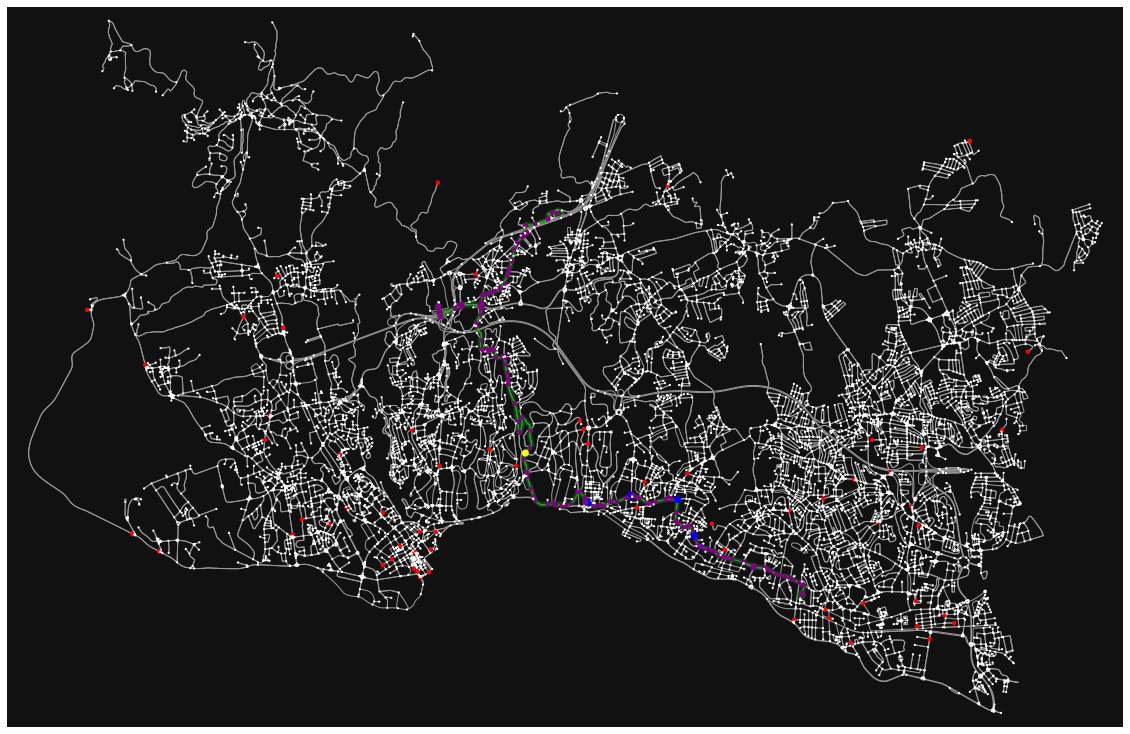

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [28]:

figsize = (20,20)

trip_id = "M01-1-001-A-U-09h15-ParedeTerminalR"

start, end = find_bus_route_nodes(bus_info, trip_id)

paths = ox.shortest_path(cascais_roads, start, end)

route_nodes = collect_paths(paths)

# find overlap nodes
disturbance_overlap_nodes = disruptions_data_sample["nearest_node"][disruptions_data_sample["nearest_node"].isin(route_nodes)]
disturbance_overlap_nodes.reset_index(drop=True, inplace=True)

test_disturbance = disturbance_overlap_nodes[4]

# find 
nc = ["yellow" if (u == test_disturbance) else 'blue' if (u in disruptions_data_sample["nearest_node"].values and u in route_nodes) else "red" if (u in disruptions_data_sample["nearest_node"].values) else "purple" if (u in route_nodes) else 'white' for u in cascais_roads.nodes()] 
ns = [50 if (u in disruptions_data_sample["nearest_node"].values and u in route_nodes) else 20 if (u in disruptions_data_sample["nearest_node"].values) else 20 if (u in route_nodes) else 5 for u in cascais_roads.nodes()] 

ox.plot_graph_route(cascais_roads, route_nodes, node_zorder=3, node_color=nc, node_size=ns, route_color="green",route_linewidth=5, figsize=figsize) 


Proposed new route, circumventing blocked road
- Going for shortest route possible

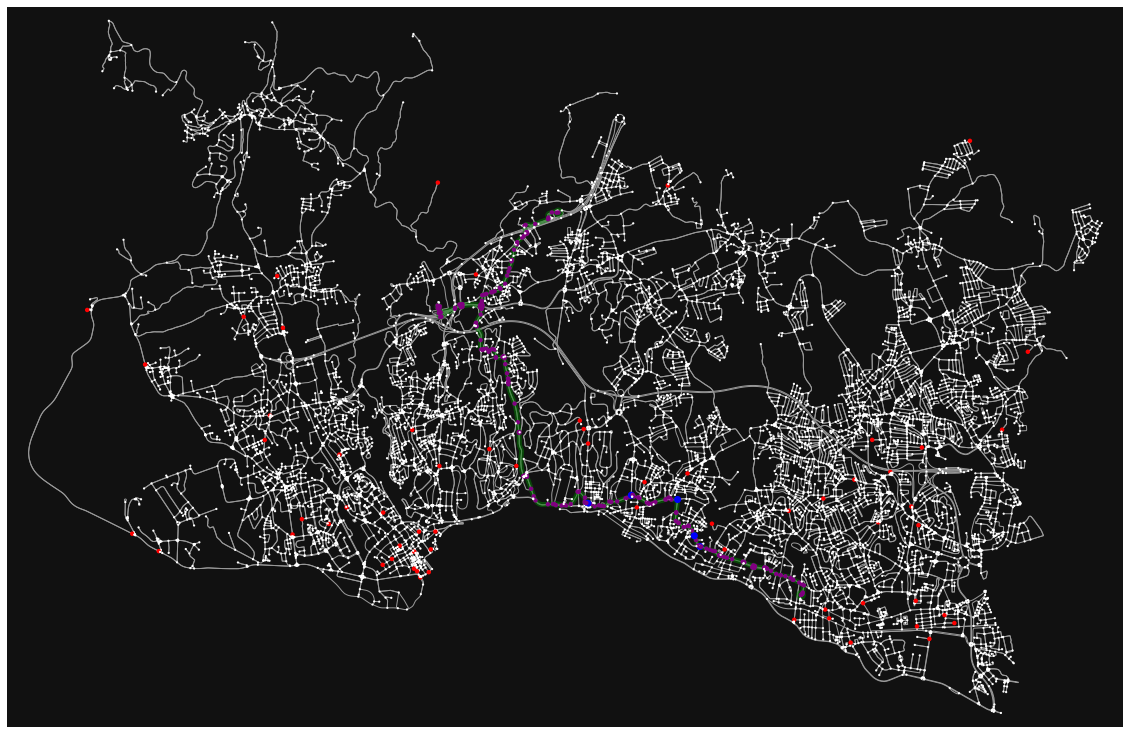

In [29]:
new_route_node = new_route_graph(cascais_roads, test_disturbance, disruptions_data_sample, figsize, start, end)


## 🖼️ Visualisations

- See graphs above


## 👓 References
* [Users without info, consider wait time 15% longer](https://ojp-content.s3.us-east-2.amazonaws.com/NHI/Old/BaseImages/2014/04/d.pdf)
* [Crowding is linear, but willingness to wait is not e.g. 50% would wait 10 min extra too avoid highly crowded. 10% to avoid moderately crowded.](https://transp-or.epfl.ch/heart/2020/abstracts/HEART_2020_paper_147.pdf)
* [Value of wait time is no-linear, big british meta study](https://eprints.whiterose.ac.uk/2062/1/)

## ⏭️ Appendix

In [30]:
now = datetime.datetime.now()
print(f"latest run: {now}")



latest run: 2022-04-23 12:45:45.506078
